# Subspace-constrained Reconstruction for Inversion-prepared T1 Mapping in BART

This tutorial uses the BART command-line inteface (CLI) (http://mrirecon.github.io/bart/) and presents how to use BART for inversion-prepared T1 Mapping using subspace-constrained reconstruction.

Main Reference:

Wang X, Tan Z, Scholand N, Roeloffs V, Uecker M. Physics-based reconstruction methods for magnetic resonance imaging. accepted to Philos. Trans. R. Soc. A. arXiv:2010.01403.

Author: Xiaoqing Wang, University Medical Center Göttingen (xiaoqing.wang@med.uni-goettingen.de)

### 1. Prerequisites

Make sure these paths are set correctly

`TOOLBOX_PATH=/Your/path/to/bart`

`PATH=$TOOLBOX_PATH:$PATH`

In [1]:
echo "BART version"
bart version

# BASH function to write BART file to png,
# display the png, and then remove it
function imshow () {
    bart toimg -W $1 $1.png > /dev/null
    cat $1.png | display
}
export -f imshow

function imshow_colormap () {
    python3 save_maps.py $1 viridis 0 2.0 $1.png > /dev/null
}
export -f imshow_colormap

# BASH function to visualize timesteps of BART cfl file
function show_timesteps () {

    data=$1
    shift
    pos=("$@")

    ind=0

    for t in "${pos[@]}"
    do
       bart slice 5 $t $data _slice$ind
       ind=$((ind+1))
    done

    bart join 6 `seq -f "_slice%g" 0 $((ind-1))` _slices
    
    DIM=`bart show -d 0 _slices`

    bart reshape $(bart bitmask 1 6) $((DIM*ind)) 1 {_,}slices

    imshow slices
}
export -f show_timesteps

BART version
v0.7.00


### 2. Introduction

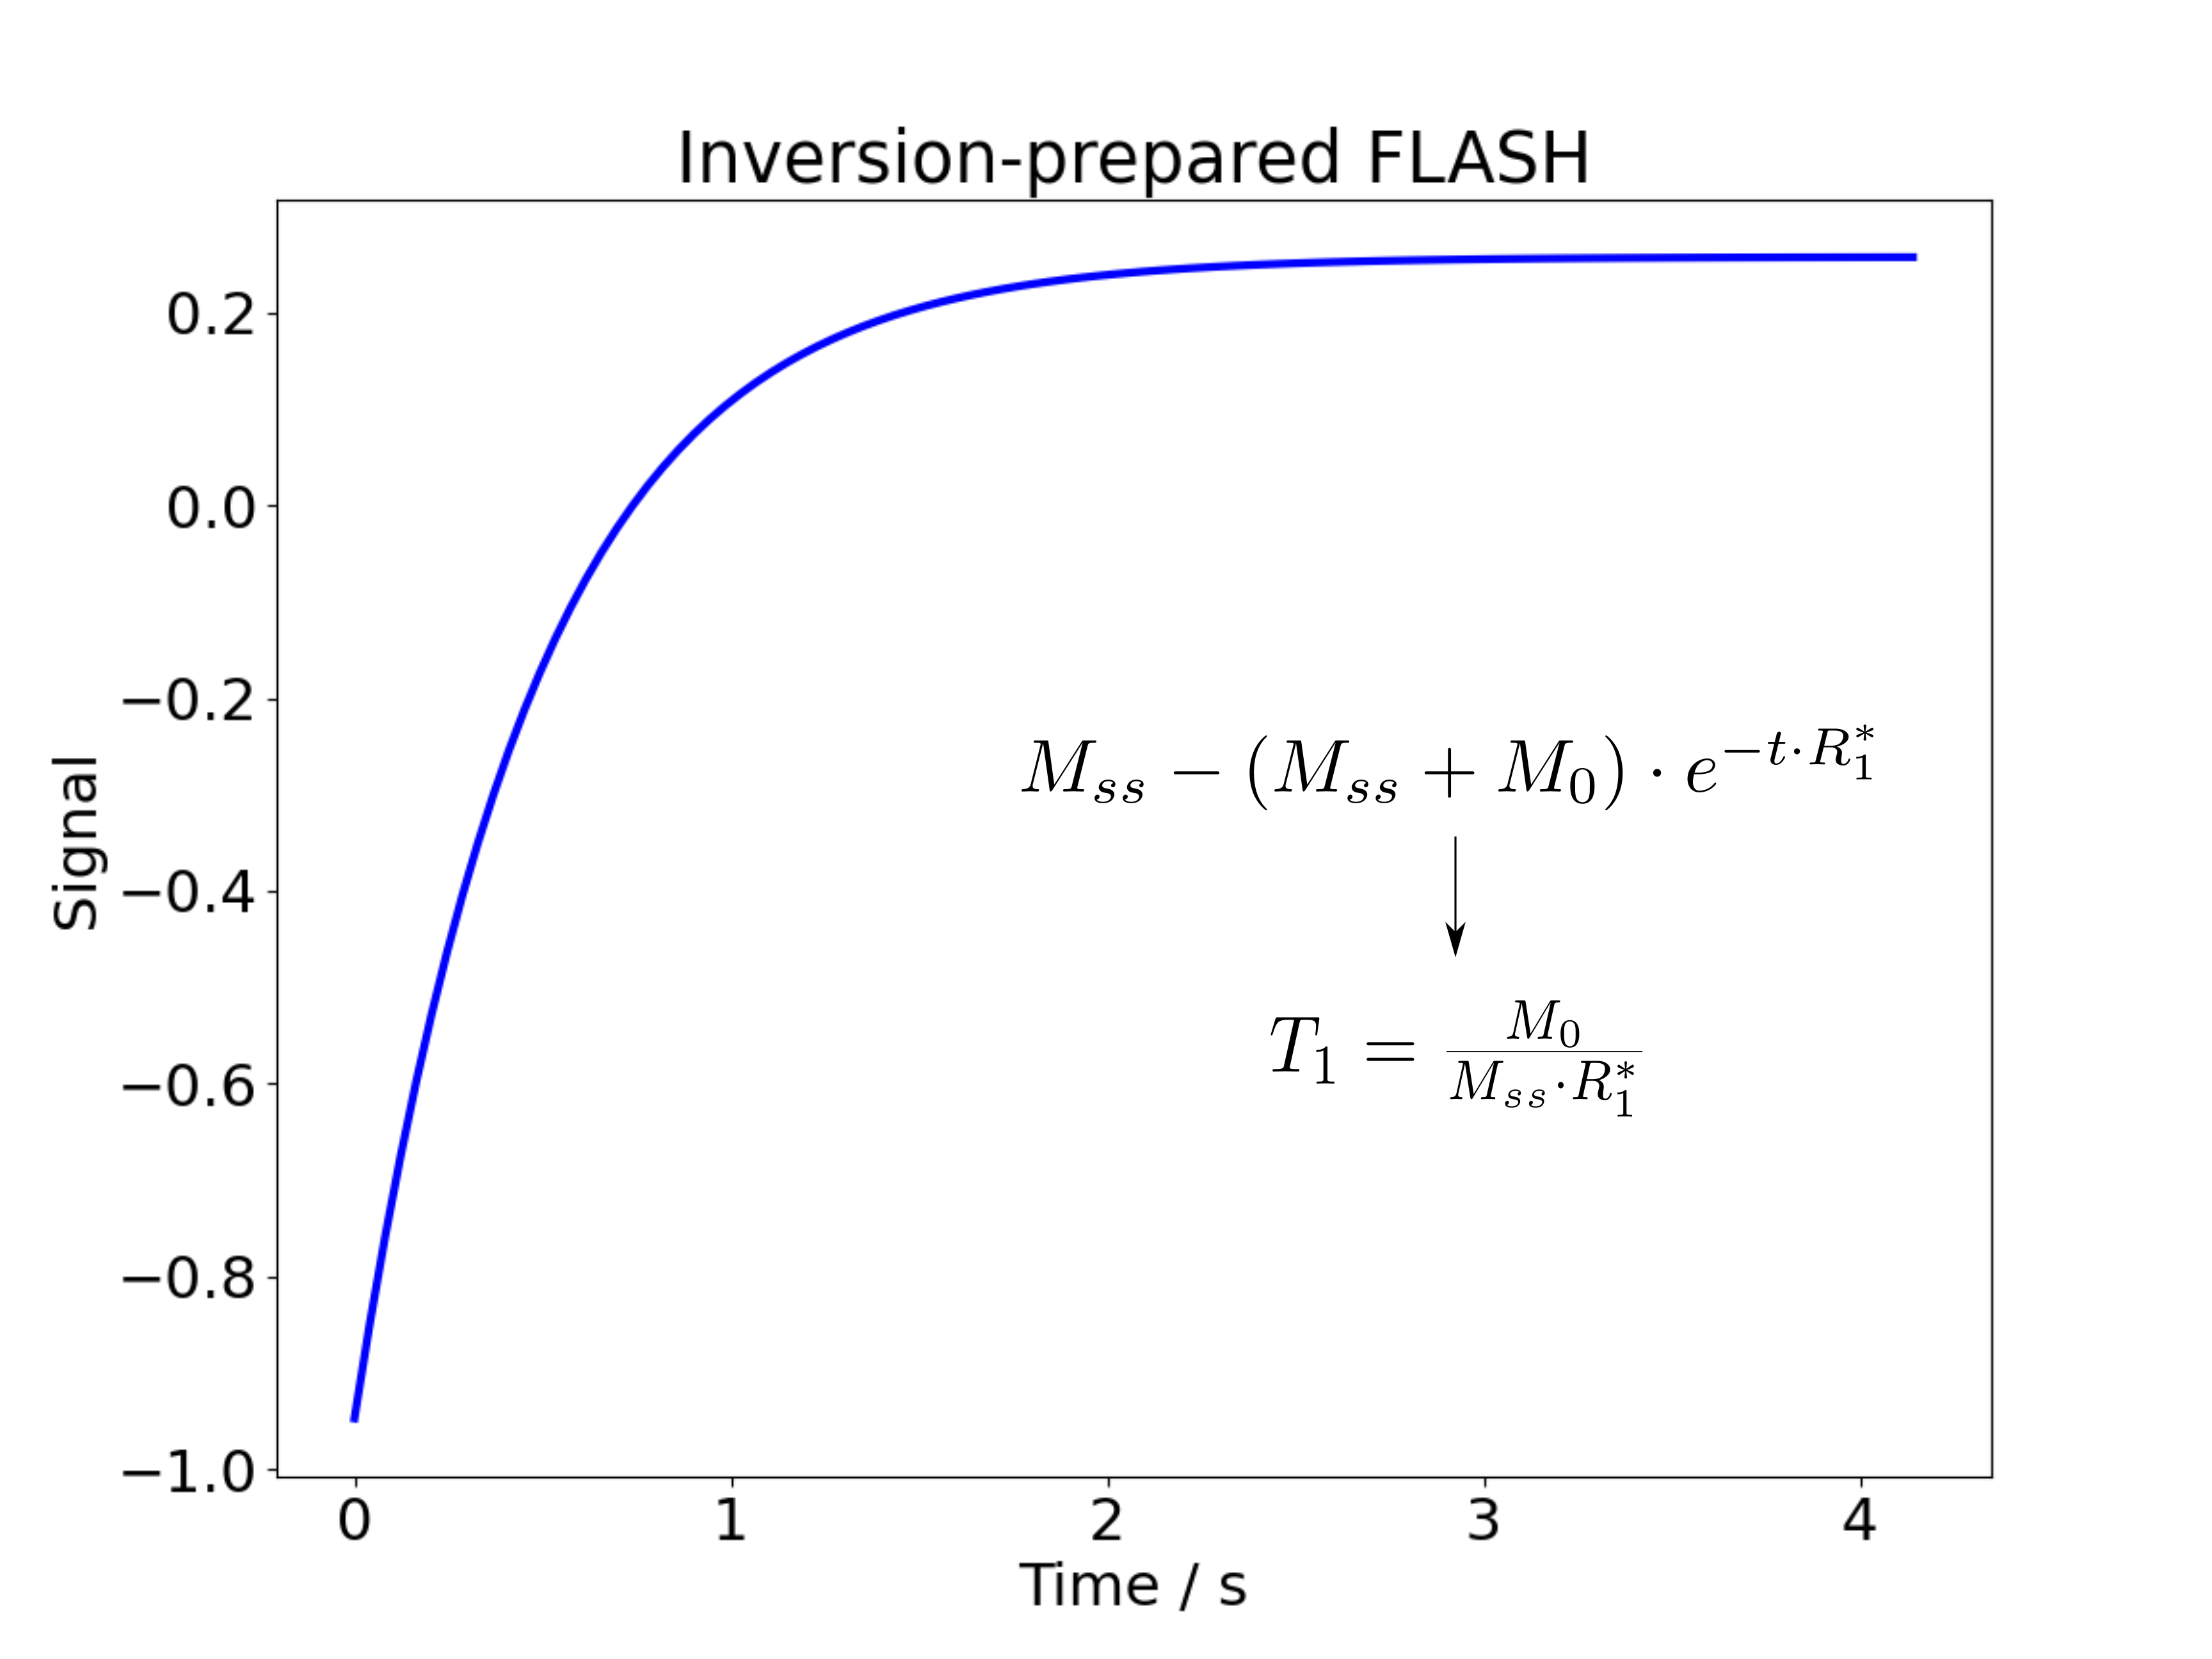

In [13]:
cat IR_FLASH.png | display 

### 3. Simulations

### 3.1 Simulate the inversion-prepared radial FLASH raw data using the phantom tool in BART

Similar to the previous example,  we can create a numerical phantom with the inversion-prepared radial FLASH sequence

In [25]:
# Define Sequence Parameters
TR=0.006 # [s]
DIM=384 # Readouts
SPOKES=1
REP=700 # Repetitions
NC=8 # Number of Coils
BR=$((DIM/2)) # Base resolution, as DIM includes two-fold oversampling

# create trajectory
bart traj -x $DIM -y $SPOKES -t $REP -c -r -G _traj
bart transpose 5 10 _traj traj
bart scale 0.5 traj traj1

# check the dimensions of traj1
head -n2 traj1.hdr

# Dimensions
3 384 1 1 1 700 1 1 1 1 1 1 1 1 1 1 


In [26]:
# create geometry basis functions
bart phantom -s$NC -T -k -b -t traj1 _basis_geom

# check the dimensions
head -n2 _basis_geom.hdr

# Dimensions
1 384 1 8 1 700 11 1 1 1 1 1 1 1 1 1 


In [27]:
# create signal basis functions
bart signal -F -I -n$REP -r$TR  -1 0.2:2.2:10 -2 0.045:0.045:1 _basis_simu_tubes
bart signal -F -I -n$REP -r$TR  -1 3:3:1 -2 1:1:1 _basis_simu_water

# flags:
#        -F FLASH
#        -I Inversion recovery
#        -n Number of RF excitations
#        -r TR (in second)
#        -1 Range for T1
#        -2 Range for T2

bart join 6 _basis_simu_water _basis_simu_tubes _basis_simu

# check the dimensions
head -n2 _basis_simu.hdr

# Dimensions
1 1 1 1 1 700 11 1 1 1 1 1 1 1 1 1 


In [28]:
# create simulated dataset
bart fmac -s $(bart bitmask 6) _basis_geom _basis_simu phantom_ksp

# check the dimensions of phantom_ksp
head -n2 phantom_ksp.hdr

# Dimensions
1 384 1 8 1 700 1 1 1 1 1 1 1 1 1 1 


In [29]:
# add noise to the simulated dataset 
bart noise -n1 phantom_ksp phantom_ksp_noisy

# generate a roi mask for later use
bart phantom -x$BR -T roi_mask 

#### 3.2 Coil sensitivity estimation using the steady-state data by ESPiRIT
Due to the contrast and phase change in the beginning of inversion, here we use the steady-state data to estimate the coil sensitivities.

In [30]:
# set to false to perform actual computation

if true; then
    bart copy ref/sens_precomp sens
else
    # extract the steady-state data
    nstate=300
    bart extract 5 $((REP-nstate)) $REP traj traj_state
    bart extract 5 $((REP-nstate)) $REP phantom_ksp_noisy phantom_ksp_state
    bart transpose 2 5 traj_state traj_state1
    bart transpose 2 5 phantom_ksp_state phantom_ksp_state1

    # apply inverse nufft 
    bart nufft -i -d$DIM:$DIM:1 traj_state1 phantom_ksp_state1 img
    
    # transform back to k-space and compute sensitivities
    bart fft -u $(bart bitmask 0 1 2) img ksp

    # transpose because we already support off-center calibration region
    # in dim 0 but here we might have it in 2
    bart ecalib -S -t0.01 -m1 ksp sens
fi

### 3.3 Linear subspace reconstruction

### 3.3.1 Generate the dictionary, perform SVD and create the temporal basis

In [31]:
# Generate the dictionary, perform SVD and
# Mss - (Mss + M0) * exp(-t * R1s)
nR1s=1000
nMss=100 
bart signal -F -I -n$REP -r$TR -1 5e-3:5:$nR1s -3 1e-2:1:$nMss dicc

# flags:
#        -F FLASH
#        -I Inversion recovery
#        -n Number of RF excitations
#        -r TR (in second)
#        -1 Range for R1*: (5e-3, 5) [1/s]
#        -3 Range for Mss: (1e-2, 1) * M0

# reshape the dicc to have all the elements on the 6th dimension
bart reshape $(bart bitmask 6 7) $((nR1s * nMss)) 1 dicc dicc1
head -n2 dicc1.hdr
# squeeze the dicc1 before SVD
bart squeeze dicc1 dicc2
head -n2 dicc2.hdr

# Dimensions
1 1 1 1 1 700 100000 1 1 1 1 1 1 1 1 1 
# Dimensions
700 100000 


In [32]:
# perform svd, S is the eigenvalue vector, while U contains the temporal basis
bart svd -e dicc2 U S V

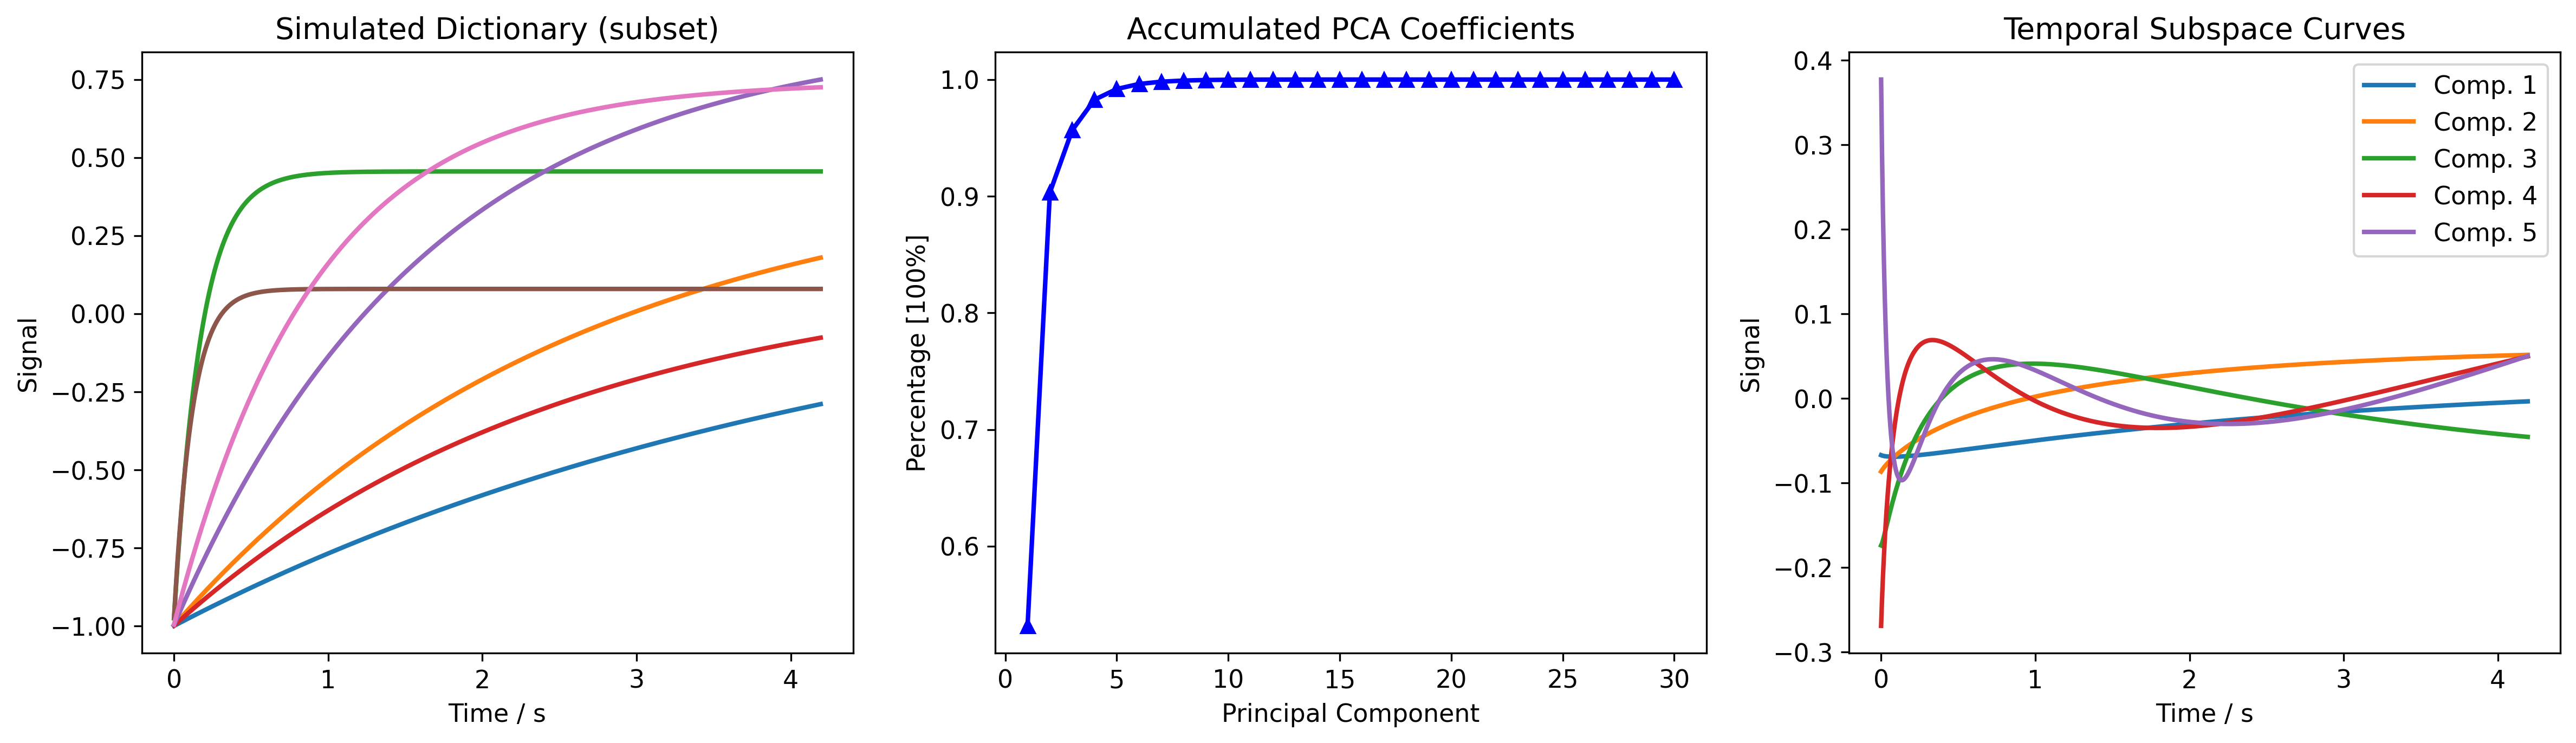

In [33]:
if true; then
    python3 python/plot_subspace_T1.py
fi
cat Subspace_T1.png | display 

In [34]:
# create the temporal basis
nCoe=4 # use 4 coefficients
bart extract 1 0 $nCoe U basis
# transpose the basis to have time on the 6th dimension and coefficients on the 5th dimension
bart transpose 1 6 basis basis1
bart transpose 0 5 basis1 basis_${nCoe}
head -n2 basis_${nCoe}.hdr

# Dimensions
1 1 1 1 1 700 4 1 1 1 1 1 1 1 1 1 


### 3.3.2 Perform subspace-constrained reconstruction with joint l1-Wavelet constraints on the coefficient maps

In [35]:
ITER=100
REG=0.0005

# set to false to perform actual computation
if true; then
    bart copy ref/subspace_reco_precomp subspace_reco
else
    # reconstruction with subspace constraint
    bart pics -e -d5 -i$ITER \
              -RW:$(bart bitmask 0 1):$(bart bitmask 6):$REG \
              -B basis_${nCoe} \
              -t traj phantom_ksp_noisy sens subspace_reco
fi

# flags:
#        -d debug level
#        -e scale stepsize based on maximal eigenvalue
#        -R W:3:3:64 joint l1-Wavelet regularization with spatial decimation

# resize the coefficient maps to the original size and multiply it with the roi_mask
bart resize -c 0 $BR 1 $BR subspace_reco tmp
bart fmac roi_mask tmp tmp_masked

In [36]:
# reshape the resutls for display
bart reshape $(bart bitmask 1 6) $((BR*nCoe)) 1 tmp_masked subspace_maps

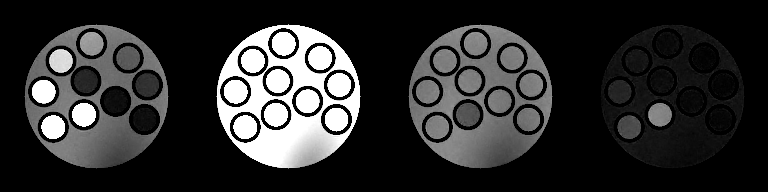

In [37]:
imshow subspace_maps

### 3.3.3 Project the reconstructed coefficient maps to images and perform pixel-wise fitting to obtain T1 map

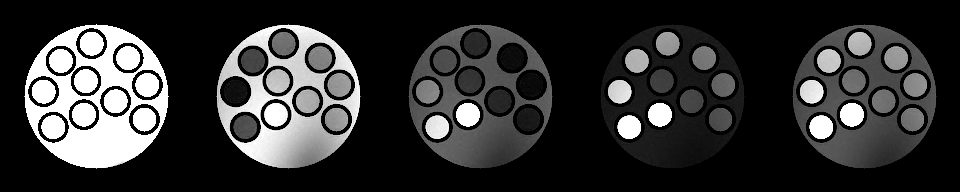

In [38]:
# multiply the basis with the subspace coefficient maps to obtain the projected images
bart fmac -s $(bart bitmask 6) basis_${nCoe} tmp_masked imgs
# and show representative T1-weighted images
t=( 0, 50, 100, 200, 600 )

show_timesteps imgs "${t[@]}"

Thank you for your participation! Feel free to ask any questions:)